In [1]:
import numpy as np
from itertools import combinations
from collections import defaultdict
from numpy.random import exponential
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# Question 1
The random variable X and Y have the following joint probability density 

$f_{XY}(x, y) = $
$\begin{cases}
e^{-x-y}, & 0 < x <\infty, 0 < y < \infty \\
0, & elsewhere
\end{cases}
$

What is $𝑃(𝑋<𝑌)$ ?

## Using conditional probabilty 
First compute marginal probability:

$f_X(x) = \int_0^{\infty} e^{-x-y} dy = e^{-x}$ and $f_Y(y) = \int_0^{\infty} e^{-x-y} dx = e^{-y}$.

Then using conditional probability:

$P(X<Y)$ 

$=\int_0^{\infty} P(X<y | Y=y)f_Y(y)dy$

$=\int_0^{\infty}(1 - e^{-y})e^{-y}dy$

$=\int_0^{\infty} e^{-y}dy - \int_0^{\infty}e^{-2y}dy$

$= 1 - \frac{1}{2} = \frac{1}{2}$



## Using Monte Carlo algorithm rooted in LLN

In [3]:
def monte_carlo_algo(sample_size):
    x = exponential(scale=1, size=sample_size)
    y = exponential(scale=1, size=sample_size)
    return (x < y).sum()/sample_size

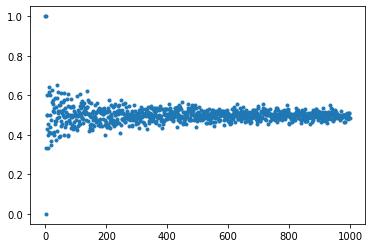

In [4]:
# As the number of samples gets larger, the results converges to 1/2.

probabilities = [monte_carlo_algo(i + 1) for i in range(1000)]
plt.plot(probabilities, '.');

# Question 2

    Counting the pairs with k different from an integer list 
    eg: list = [1, 3,5] and k = 2 
    expected: we will have 2 pairs: {(1,3), (3,5)} 
    Note: we also consider the negative numbers.

In [5]:
# Do not consider the order of numbers in each pair. Assume duplicated pairs are allowed.
# First traverse the list and record the number of apperance of each element.
# Sort the unqiue numbers, for each number, check whether number + k exist.
# Time complexity is O(n), space complexity is O(n).

def count_paris(alist, k):
    numbers = defaultdict(int)
    for num in alist:
        numbers[num] += 1
        
    unique_num = list(numbers.keys()) 
    unique_num.sort()
    
    count = 0
    pairs = []
    
    for num in unique_num:
        if num + k in unique_num:
            c = numbers[num] * numbers[num+k]
            pairs += [(num, num+k) for i in range(c)]
            count += c
            
    print(f"we will have {count} pairs: {pairs}")       

In [6]:
# test the code 

count_paris([1, 3, 5], 2)
count_paris([1, 3, 3, 5], 2)

we will have 2 pairs: [(1, 3), (3, 5)]
we will have 4 pairs: [(1, 3), (1, 3), (3, 5), (3, 5)]


# Question 3

    Return the list of indices. The indices is a sublist points to the same person. The same persons means they have the same name or email or phone. eg:
    data = [
    ("username1","phone_number1", "email1"),
    ("usernameX","phone_number1", "emailX"),
    ("usernameZ","phone_numberZ", "email1Z"),
    ("usernameY","phone_numberY", "emailX"),
    ]
    expected: [[0,1,3][2]]

In [7]:
# Build adjency graph with contacts as nodes and contact details as links.

def build_graph(data):
    n = len(data)
    graph = np.zeros((n, n))
    for i in range(n-1):
        for j in range(i+1, n):
            if data[i][0] == data[j][0] or data[i][1] == data[j][1] or data[i][2] == data[j][2]:
                graph[i][j] = 1
                graph[j][i] = 1
    return graph        

In [8]:
# Perform depth first search using a recuesive function.

def depth_first_traverse(graph, n, i, visited, res):
    visited[i] = True
    res.append(i)
    for j in range(n):
        if graph[i][j] == 1 and not visited[j]:
             depth_first_traverse(graph, n, j, visited, res)      

In [9]:
# Indentify same persons.

def identify_same_person(data):
    graph =  build_graph(data)
    n = len(data)
    results = []
    visited = [False for i in range(n)] 
    for i in range(n):
        if not visited[i]:
            res = []
            depth_first_traverse(graph, n, i, visited, res)
            results.append(res)
    return results

In [10]:
# test the code with example

data = [
    ("username1","phone_number1", "email1"),
    ("usernameX","phone_number1", "emailX"),
    ("usernameZ","phone_numberZ", "email1Z"),
    ("usernameY","phone_numberY", "emailX"),
    ]

identify_same_person(data)

[[0, 1, 3], [2]]

# Question 4

Implement the Forward propagation & Backward propagation for a three layers Neural Network. X, W and b can be random.

In [11]:
class NeuralNetwork:
    def __init__(self, sizes):
        """
        The list sizes contains the number of neurons in the respective layers of the network.
        """    
        self.num_layer = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(m, 1) for m in sizes[1:]]
        self.weights = [np.random.randn(m, n) for m, n in zip(sizes[1:], sizes[0: -1])]
     
    def feed_forward(self, x):
        """
        The formulations in feed forward algorithm are in matrix form.
        """
        n = len(x)
        activation = x
        activations = [x]
        zs = []
        for weight, bias in zip(self.weights, self.biases):
            z = activation @ weight.T + bias.T
            activation = self.sigmoid(z) 
            zs.append(z)
            activations.append(activation)
        return zs, activations
    
    def back_prop(self, x, y):
        """
        The formulations in backward propagation algorithm are in matrix form.
        """
        zs, activations = self.feed_forward(x)
    
        nudge_biases = [np.zeros(b.shape) for b in self.biases]
        nudge_weights = [np.zeros(w.shape) for w in self.weights]
        
        n = len(x)
        delta = self.cost_derivative(activations[-1], y) * self.sigmoid_derivative(zs[-1])
        nudge_biases[-1] = delta.T @ np.ones((n, 1))
        nudge_weights[-1] = delta.T @ activations[-2]
    
        for i in range(2, self.num_layer):
            delta = (delta @ self.weights[-i+1]) * self.sigmoid_derivative(zs[-i])
            nudge_biases[-i] =  delta.T @ np.ones((n, 1))
            nudge_weights[-i] = delta.T @ (activations[-i-1])
        return nudge_biases, nudge_weights
      
    def update_params(self, x, y, epochs, rate):
        """
        Train data using backward propagation algorithm.
        Here, use the whole train data set as a mini batch.
        """
        for j in range(epochs):
            nudge_biases, nudge_weights = self.back_prop(x, y)
            self.biases = [b - rate * nb for b, nb in zip(self.biases, nudge_biases)]
            self.weights = [w - rate * nw for w, nw in zip(self.weights, nudge_weights)] 
    
    def predict(self, x):
        """
        Return neural network output given input x.
        """
        _, act = self.feed_forward(x)
        return act[-1]
    
    @staticmethod
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        f = self.sigmoid(x)
        return f * (1 - f)
    
    @staticmethod
    def cost_derivative(y_pred, y_true):
        """
        Give derivative of cost function in the form of \sum(y_pred - y_true) ** 2 / 2
        """
        return y_pred - y_true

In [12]:
# generate random variable x, y

x = np.random.rand(1000, 3)
y = x.mean(axis=1).reshape(-1, 1)

In [13]:
# use the back propagation to train data

nn = NeuralNetwork((3, 2, 1))
nn.update_params(x, y, 200, 0.01)
y_pred = nn.predict(x)
print(f'mean squre error is: {((y_pred - y) ** 2).mean()}')

mean squre error is: 0.0013237859175152238


In [14]:
# use the sklearn app MLPRegressor to train data

regr = MLPRegressor(activation='logistic', batch_size=1000, learning_rate_init=0.01)
regr.fit(x, y.flatten())
print(f'mean square error is: {((regr.predict(x) - y) ** 2).mean()}')

mean square error is: 0.04673068547638259
